In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
!pip install hurst
from hurst import compute_Hc

In [ ]:
# prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')
# prices = prices.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.name != 'Timestamp' else col)
# prices.iloc[:, 1:] = np.abs(prices.iloc[:, 1:])
prices = pd.read_csv('finaldata.csv', parse_dates=['Timestamp'], index_col='Timestamp')

prices = prices.apply(lambda col: col.abs() if col.name != 'Timestamp' else col)




In [ ]:
cumret = np.log(prices).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)

In [ ]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]

    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint

    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]

    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]

    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - hedge_ratio*cumret[s2]
        results.loc[pair]['CADF p-value'] = coint(cumret[s1], cumret[s2])[1]
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_mu = pairs_df.loc[pair]['Spread mean'] # historical mean
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        # subtract the mean to calculate distances and num_crossings
        spread_nm = spread - hist_mu
        results.loc[pair]['Distance'] = np.sqrt(np.sum((spread_nm)**2))
        results.loc[pair]['Num zero-crossings'] = ((spread_nm[1:].values * spread_nm[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread-hist_mu) < 2*hist_sd).sum() / len(spread) * 100

    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant

    for pair in pairs:
        s1,s2 = parse_pair(pair)
        res = OLS(cumret_train[s1], add_constant(cumret_train[s2])).fit()
        spread_train = cumret_train[s1] - res.params[s2]*cumret_train[s2]
        spread_test = cumret_test[s1] - res.params[s2]*cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'Num zero-crossings', 'Pearson r', 'Spread mean',
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion', 'Hedge ratio']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                if cadf_p<0.01 and (f'{s2}-{s1}' not in pairs.index): # stop if pair already added as s2-s1
                    res = OLS(train[s1], add_constant(train[s2])).fit()
                    hedge_ratio = res.params[s2]
                    if hedge_ratio > 0: # hedge ratio should be posititve
                        spread = train[s1] - hedge_ratio*train[s2]
                        hurst = compute_Hc(spread)[0]
                        if hurst<0.5:
                            halflife = calculate_halflife(spread)
                            if halflife>1 and halflife<30:
                                # subtract the mean to calculate distances and num_crossings
                                spread_nm = spread - spread.mean()
                                num_crossings = (spread_nm.values[1:] * spread_nm.values[:-1] < 0).sum()
                                if num_crossings>len(train.index)/252*12:
                                    distance = np.sqrt(np.sum(spread_nm**2))
                                    pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                    pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r, spread.mean(),
                                                               spread.std(), hurst, halflife, hedge_ratio]

    return pairs

In [ ]:
cumret48_36 = cumret.loc['2016-03-15':]
cumret48_36 = cumret48_36 / cumret48_36.iloc[0] # divide by first row so that all prices start at 1
train48_36 = cumret48_36.loc['2016-03-15':'2020-01-24'] # formation period
test48_36 = cumret48_36.loc['2020-01-25':'2022-12-06'] # trading period
pairs48_36 = select_pairs(train48_36)
pairs48_36

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr2,10.166989,75.0,0.950250,-0.032222,0.321992,0.395199,1.233077,0.973676
Instr1-Instr3,12.221508,63.0,0.927254,-0.050791,0.387059,0.346086,1.171195,0.962287
Instr1-Instr4,14.010682,57.0,0.903187,-0.070576,0.443723,0.383944,1.224167,0.943260
Instr1-Instr5,14.370313,61.0,0.897867,-0.083345,0.455112,0.363294,1.442825,0.976230
Instr1-Instr6,16.467523,57.0,0.863401,-0.106343,0.521532,0.379346,1.414543,0.924971
...,...,...,...,...,...,...,...,...
Instr17-Instr3,17.657129,68.0,0.763890,0.071853,0.559207,0.291088,2.084585,0.664528
Instr18-Instr1,22.494720,62.0,0.649270,0.063279,0.712415,0.350692,1.878428,0.588333
Instr18-Instr2,21.668472,64.0,0.680636,0.061903,0.686247,0.354123,1.840554,0.631959
Instr19-Instr1,22.707783,68.0,0.638552,0.058873,0.719163,0.335207,1.984501,0.577254


In [ ]:
pairs48_36.sort_values(by='Distance')

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr13-Instr15,5.207439,59.0,0.980251,-0.011598,0.164921,0.377067,1.046612,0.958129
Instr13-Instr16,5.990257,55.0,0.973781,-0.015984,0.189713,0.342856,1.059581,0.957957
Instr12-Instr15,7.079409,55.0,0.963564,-0.020289,0.224207,0.391095,1.157321,0.946647
Instr2-Instr3,7.224833,49.0,0.973940,-0.019601,0.228813,0.398039,1.026466,0.986419
Instr5-Instr3,7.723215,68.0,0.966340,0.015500,0.244597,0.331505,1.086225,0.922349
...,...,...,...,...,...,...,...,...
Instr19-Instr1,22.707783,68.0,0.638552,0.058873,0.719163,0.335207,1.984501,0.577254
Instr3-Instr20,22.956832,51.0,0.683547,-0.190114,0.727050,0.308934,2.101231,0.720544
Instr20-Instr1,23.382016,66.0,0.621187,0.055705,0.740516,0.343242,1.996378,0.567837
Instr2-Instr19,23.608533,51.0,0.671360,-0.205452,0.747690,0.346770,2.429826,0.724783


In [ ]:
pairs48_36.sort_values(by='Distance')


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr13-Instr15,5.207439,59.0,0.980251,-0.011598,0.164921,0.377067,1.046612,0.958129
Instr13-Instr16,5.990257,55.0,0.973781,-0.015984,0.189713,0.342856,1.059581,0.957957
Instr12-Instr15,7.079409,55.0,0.963564,-0.020289,0.224207,0.391095,1.157321,0.946647
Instr2-Instr3,7.224833,49.0,0.973940,-0.019601,0.228813,0.398039,1.026466,0.986419
Instr5-Instr3,7.723215,68.0,0.966340,0.015500,0.244597,0.331505,1.086225,0.922349
...,...,...,...,...,...,...,...,...
Instr19-Instr1,22.707783,68.0,0.638552,0.058873,0.719163,0.335207,1.984501,0.577254
Instr3-Instr20,22.956832,51.0,0.683547,-0.190114,0.727050,0.308934,2.101231,0.720544
Instr20-Instr1,23.382016,66.0,0.621187,0.055705,0.740516,0.343242,1.996378,0.567837
Instr2-Instr19,23.608533,51.0,0.671360,-0.205452,0.747690,0.346770,2.429826,0.724783


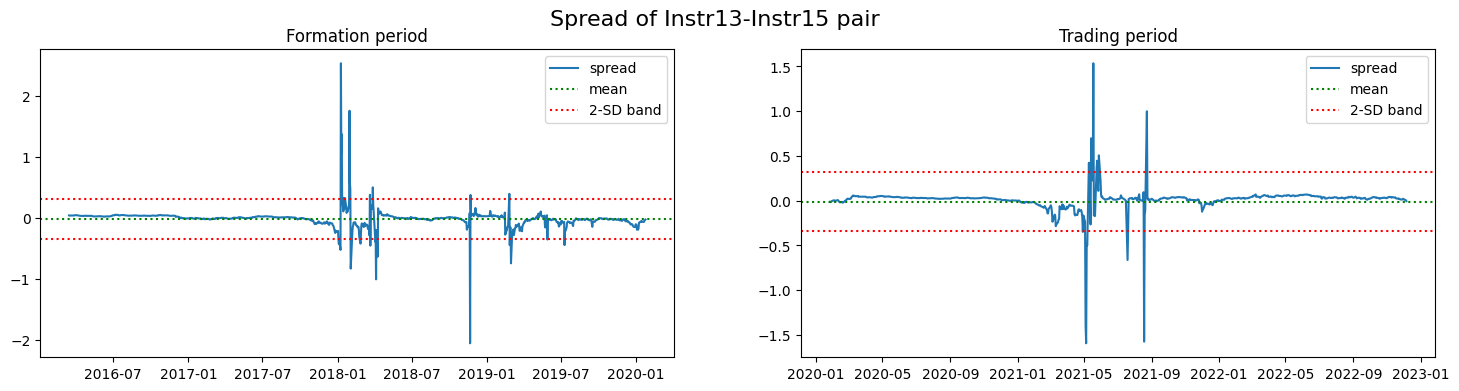

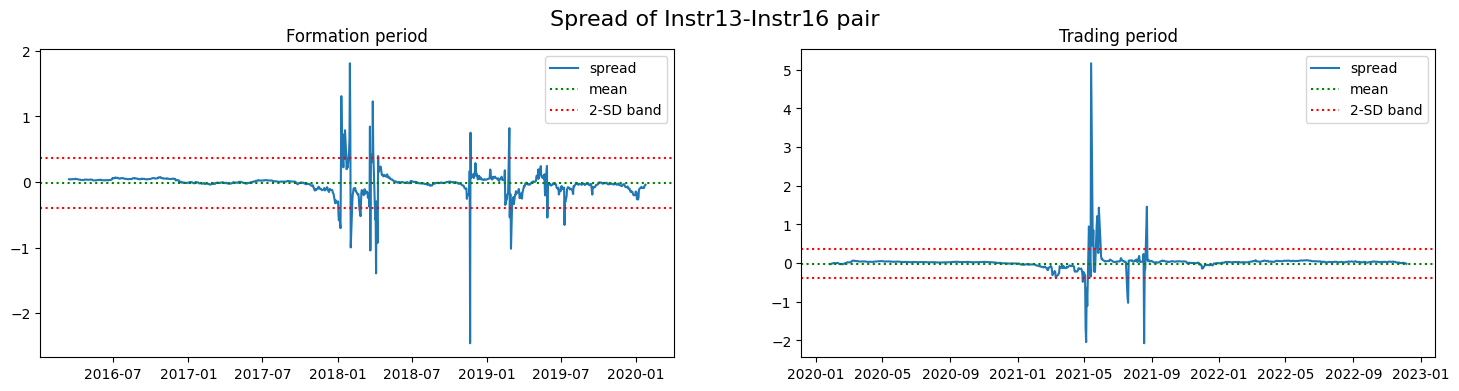

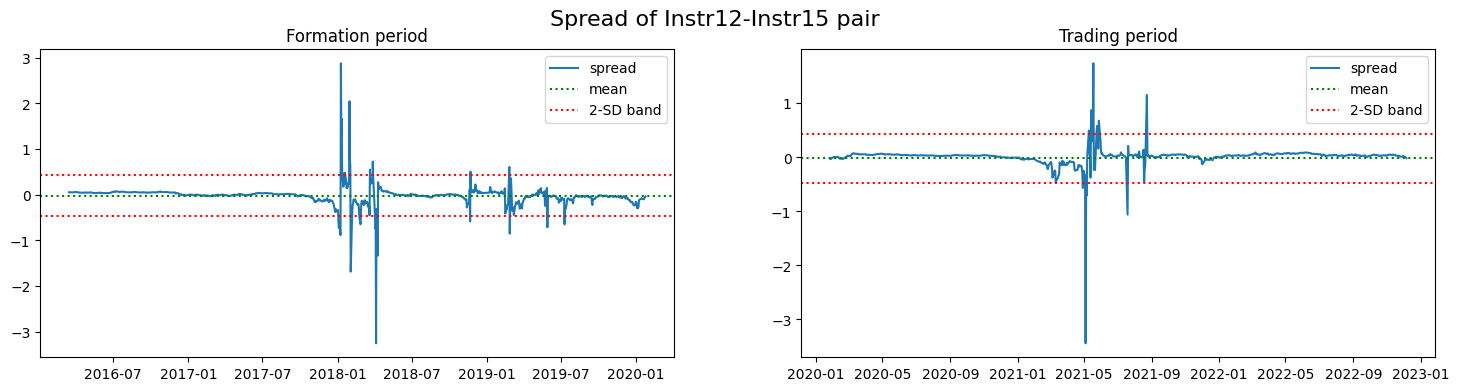

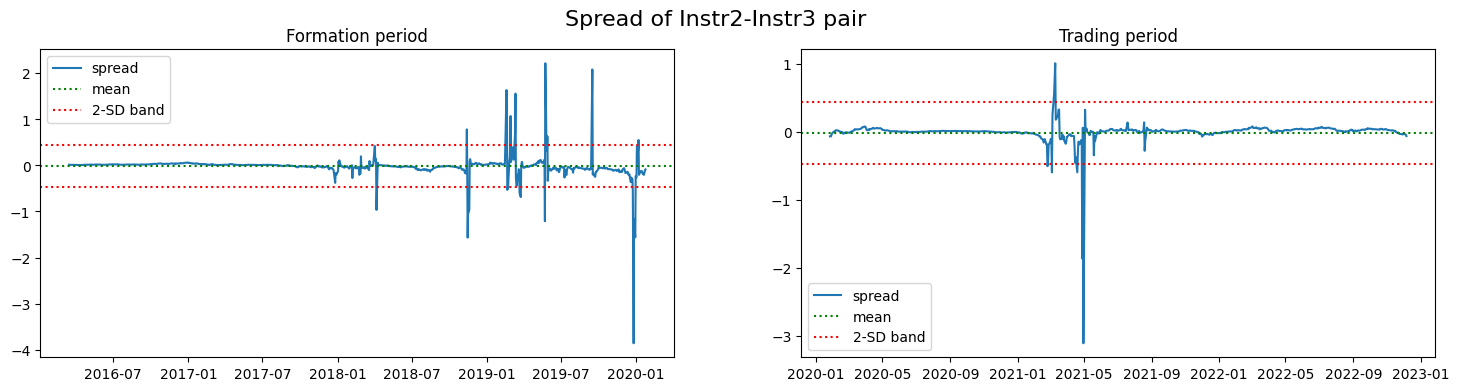

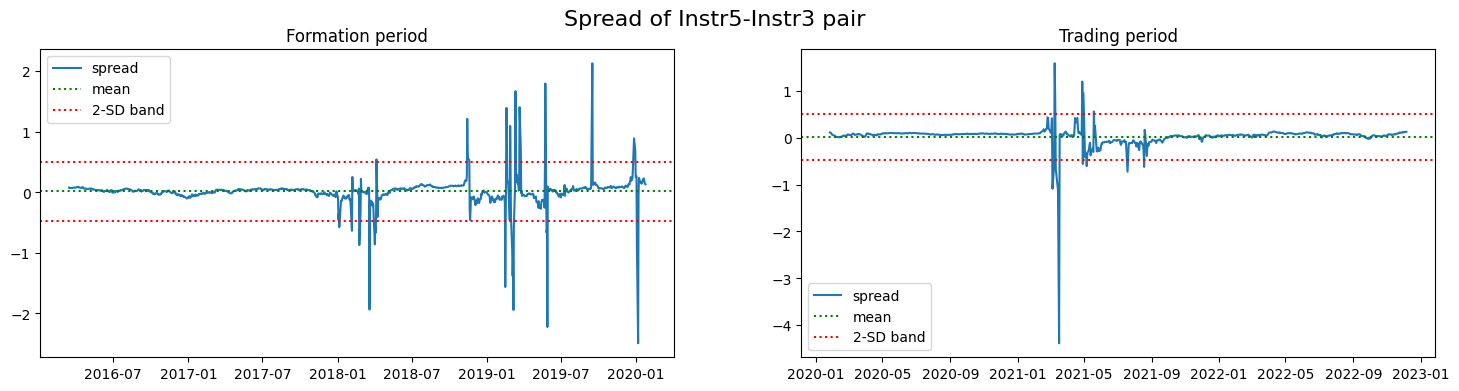

In [ ]:
top5_distance = list(pairs48_36.sort_values(by='Distance').index[:5])
plot_pairs(top5_distance, train48_36, test48_36)

In [ ]:
pairs48_36.sort_values(by='Num zero-crossings', ascending=False)

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr12-Instr1,15.740888,88.0,0.803925,0.077197,0.498519,0.336020,1.651213,0.651888
Instr10-Instr5,9.444148,86.0,0.936933,0.048451,0.299099,0.328421,1.089814,0.843343
Instr13-Instr3,14.035674,86.0,0.846101,0.074251,0.444514,0.295572,1.576632,0.708378
Instr13-Instr1,16.272322,86.0,0.786208,0.078857,0.515350,0.323201,1.904827,0.634271
Instr10-Instr6,8.877180,82.0,0.944495,0.037577,0.281143,0.339951,1.009428,0.837666
...,...,...,...,...,...,...,...,...
Instr4-Instr10,13.243300,49.0,0.905784,-0.101287,0.419420,0.329735,1.070602,1.047647
Instr6-Instr16,16.508910,49.0,0.840472,-0.123823,0.522842,0.328791,1.643807,0.956653
Instr3-Instr18,22.211365,49.0,0.708008,-0.186741,0.703441,0.324403,1.982595,0.752896
Instr4-Instr16,18.696044,49.0,0.801340,-0.159621,0.592110,0.323374,1.802752,0.935643


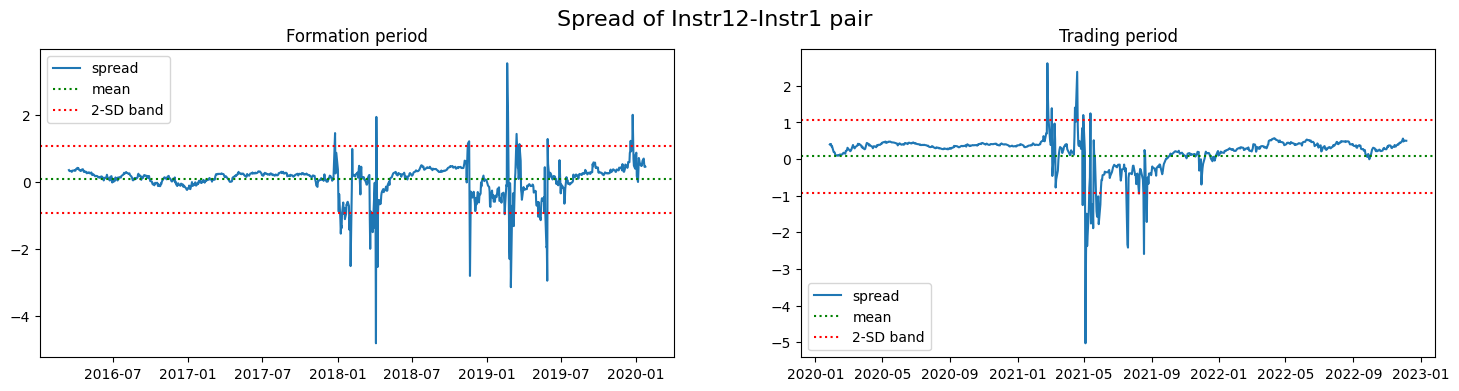

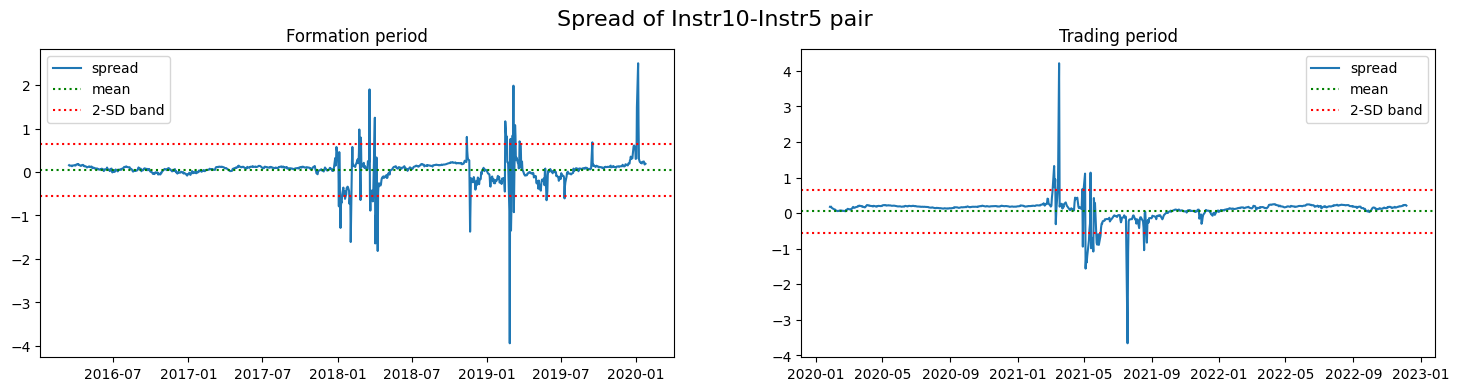

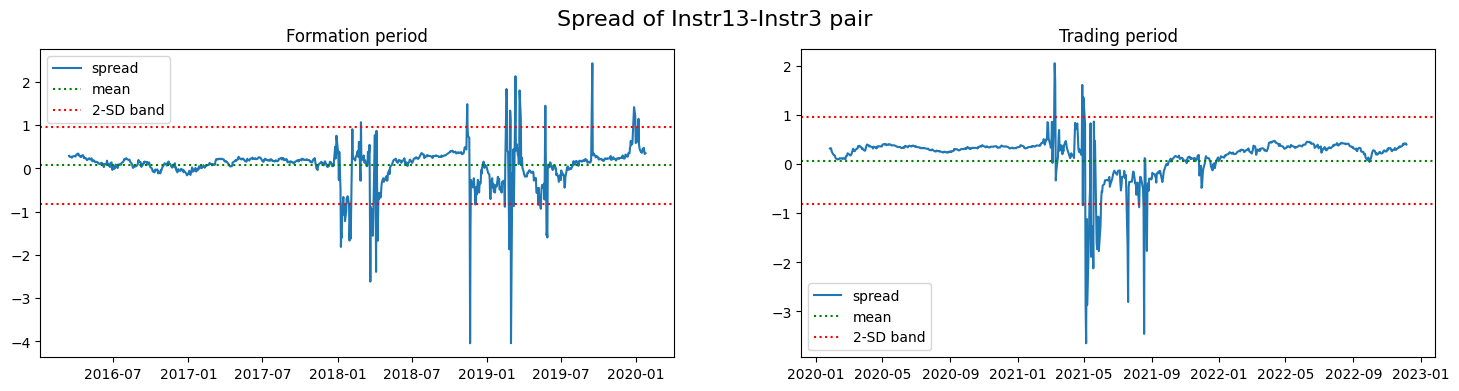

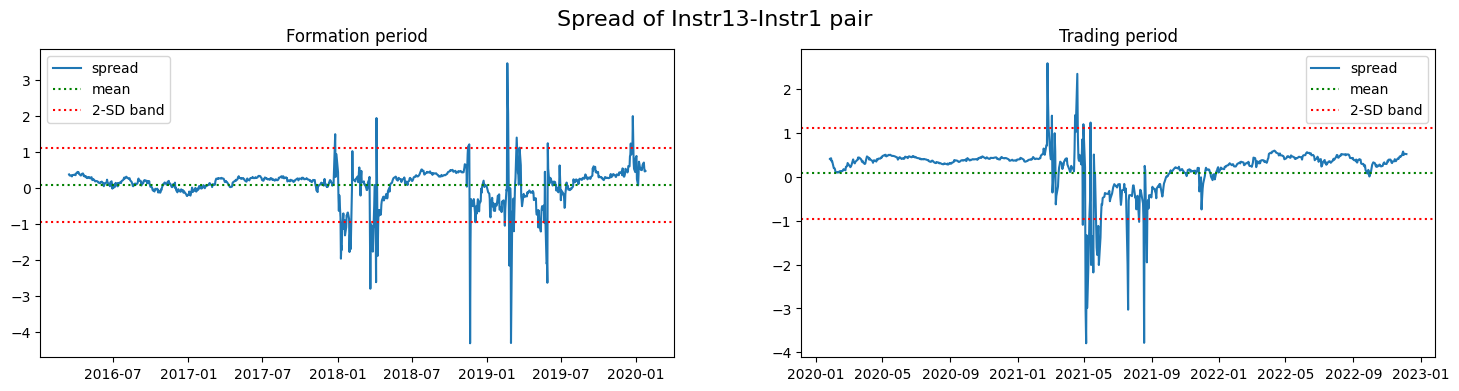

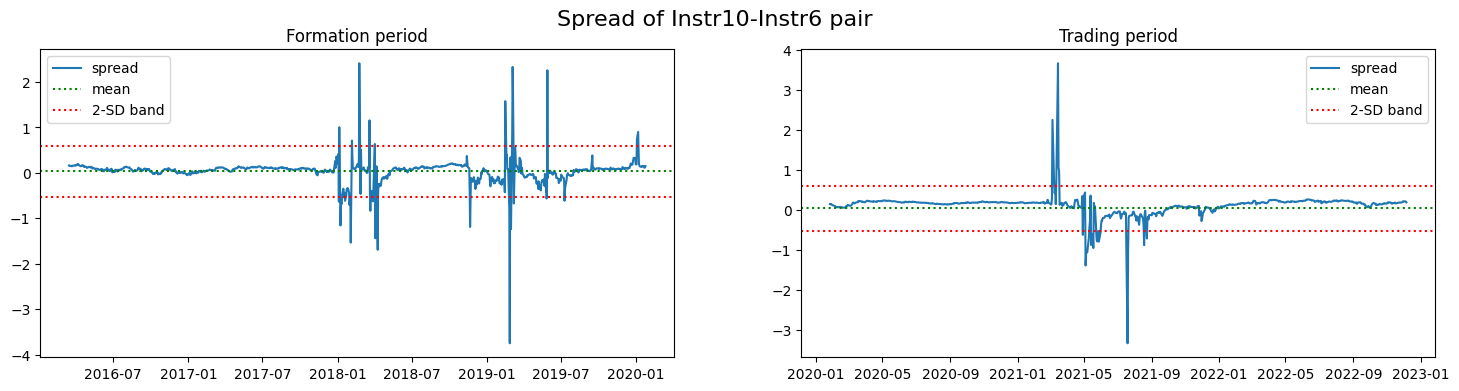

In [ ]:
top5_crossings = list(pairs48_36.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train48_36, test48_36)

In [ ]:
pairs48_36.sort_values(by='Pearson r', ascending=False)


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr13-Instr15,5.207439,59.0,0.980251,-0.011598,0.164921,0.377067,1.046612,0.958129
Instr2-Instr3,7.224833,49.0,0.973940,-0.019601,0.228813,0.398039,1.026466,0.986419
Instr13-Instr16,5.990257,55.0,0.973781,-0.015984,0.189713,0.342856,1.059581,0.957957
Instr5-Instr3,7.723215,68.0,0.966340,0.015500,0.244597,0.331505,1.086225,0.922349
Instr12-Instr15,7.079409,55.0,0.963564,-0.020289,0.224207,0.391095,1.157321,0.946647
...,...,...,...,...,...,...,...,...
Instr2-Instr19,23.608533,51.0,0.671360,-0.205452,0.747690,0.346770,2.429826,0.724783
Instr2-Instr20,24.090781,49.0,0.654260,-0.208690,0.762963,0.351028,2.521255,0.698508
Instr18-Instr1,22.494720,62.0,0.649270,0.063279,0.712415,0.350692,1.878428,0.588333
Instr19-Instr1,22.707783,68.0,0.638552,0.058873,0.719163,0.335207,1.984501,0.577254


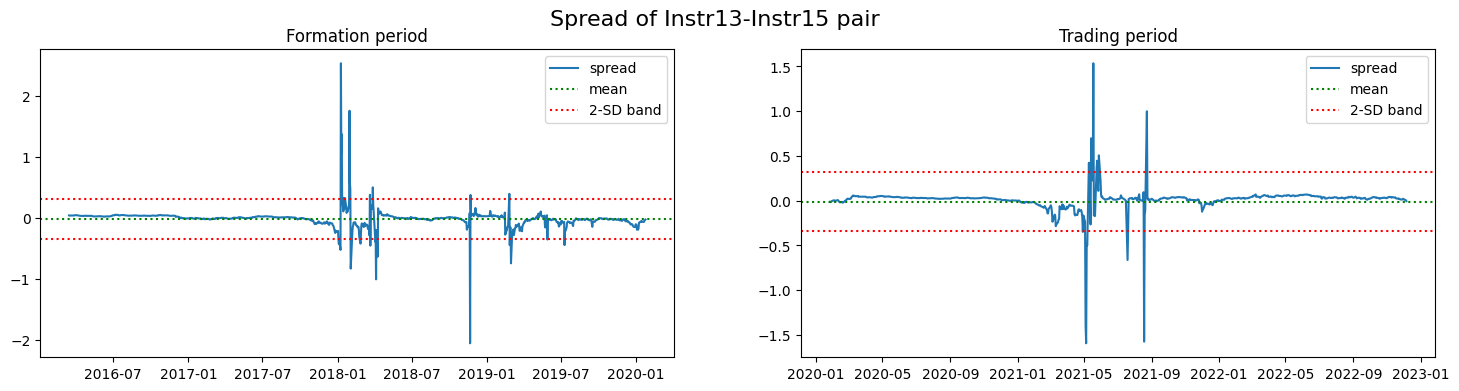

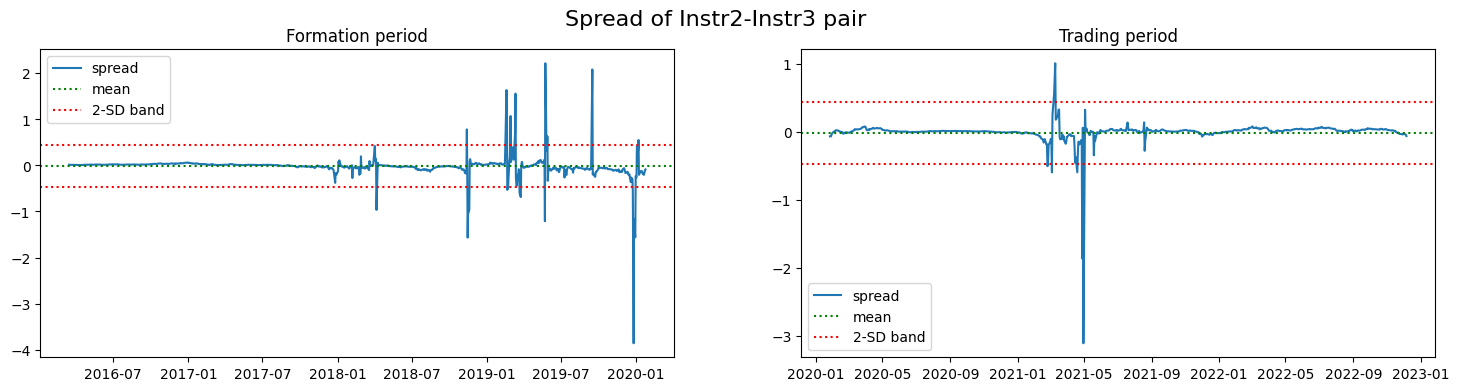

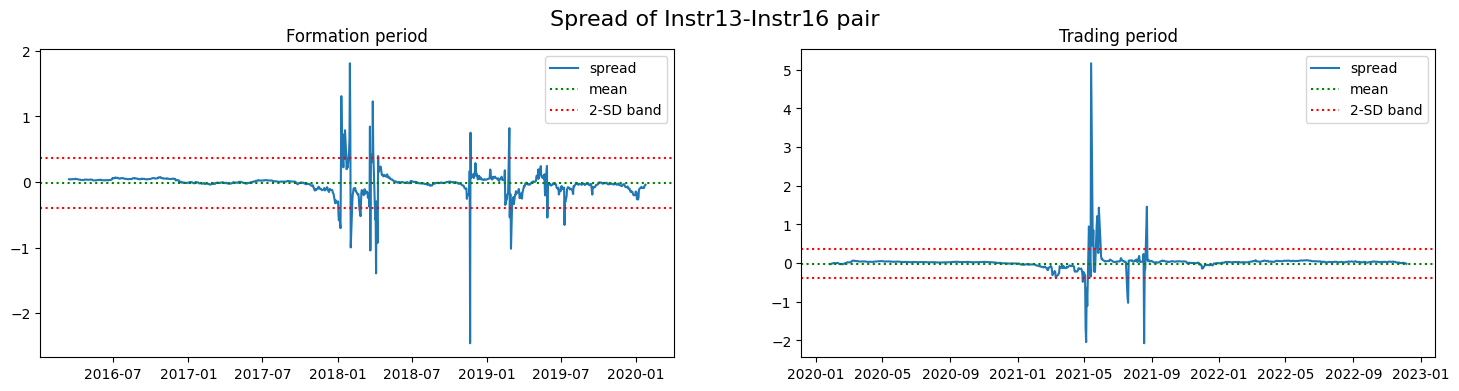

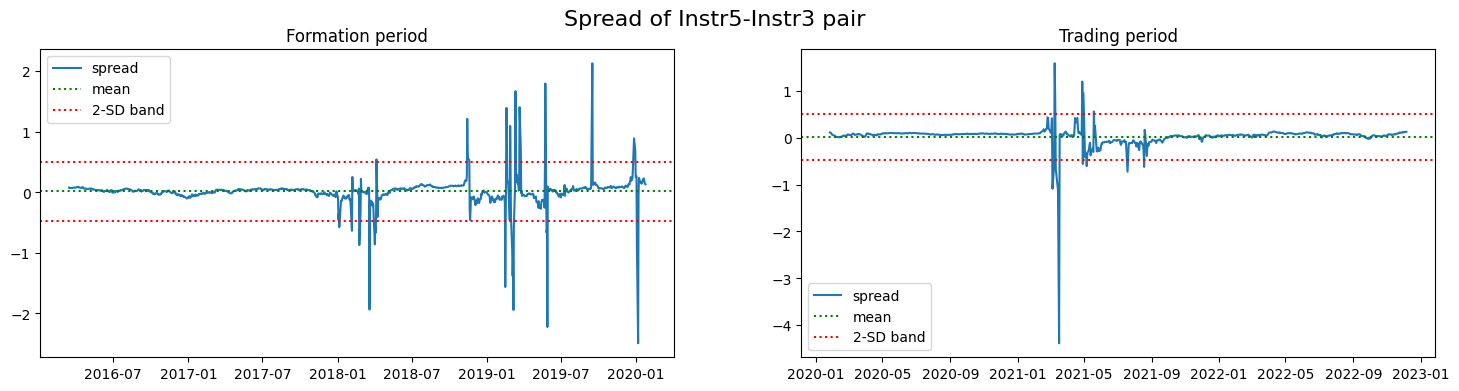

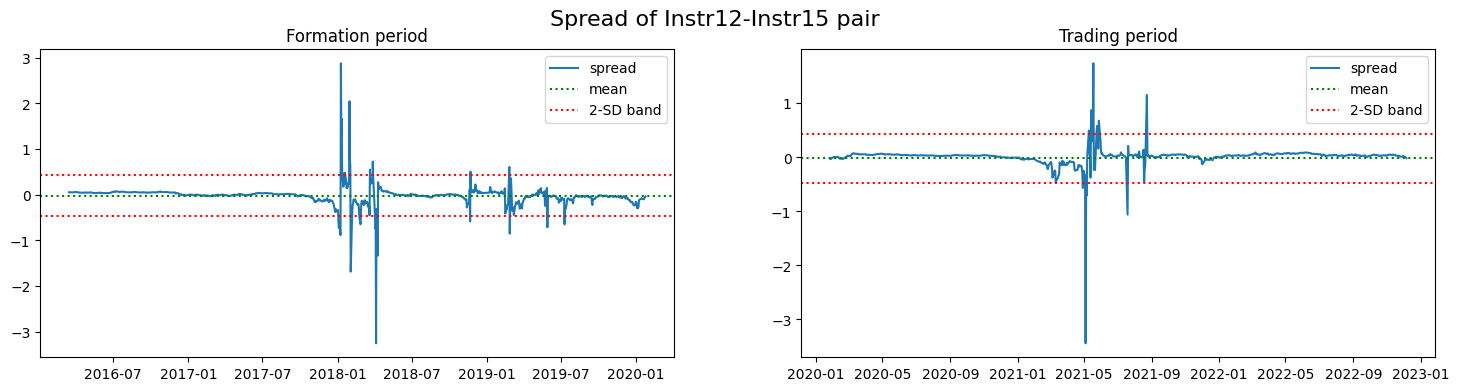

In [ ]:
top5_pearson = list(pairs48_36.sort_values(by='Pearson r', ascending=False).index[:5])
plot_pairs(top5_pearson, train48_36, test48_36)

In [ ]:
cumret60_24 = cumret.loc['2016-07-01':]
cumret60_24 = cumret60_24 / cumret60_24.iloc[0] # divide by first row so that all prices start at 1
train60_24 = cumret60_24.loc['2016-07-01':'2021-06-30'] # formation period
test60_24 = cumret60_24.loc['2021-07-01':'2023-12-05'] # trading period
pairs60_24 = select_pairs(train60_24)
pairs60_24

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr2,23.143488,86.0,0.956716,-0.060082,0.644618,0.397532,1.158968,0.950065
Instr1-Instr3,26.916062,100.0,0.940980,-0.090890,0.749696,0.332896,1.215346,0.929947
Instr1-Instr4,31.568372,84.0,0.917834,-0.126829,0.879277,0.348481,1.234478,0.859295
Instr1-Instr5,34.175304,80.0,0.902950,-0.163581,0.951888,0.344839,1.470329,0.838752
Instr1-Instr6,38.801195,76.0,0.872891,-0.202280,1.080734,0.358805,1.374257,0.781458
...,...,...,...,...,...,...,...,...
Instr18-Instr4,103.567403,64.0,0.749341,0.475840,2.884673,0.332535,1.599418,1.379753
Instr18-Instr5,99.072961,64.0,0.773785,0.443388,2.759489,0.330722,1.626964,1.413624
Instr19-Instr1,127.625487,66.0,0.683255,0.631625,3.554765,0.319512,2.106975,1.501722
Instr19-Instr2,123.601146,70.0,0.707058,0.594948,3.442675,0.325031,2.008814,1.543236


In [ ]:
pairs60_24.sort_values(by='Num zero-crossings', ascending=False)


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr3,26.916062,100.0,0.940980,-0.090890,0.749696,0.332896,1.215346,0.929947
Instr12-Instr6,41.387926,96.0,0.908574,0.240086,1.152782,0.338808,1.217230,1.013417
Instr13-Instr6,45.912117,92.0,0.895510,0.271818,1.278795,0.321421,1.372383,1.040019
Instr12-Instr4,48.256960,92.0,0.873372,0.296763,1.344106,0.330914,1.188274,1.018732
Instr12-Instr18,42.295987,90.0,0.904304,-0.074127,1.178074,0.329086,1.068108,0.572866
...,...,...,...,...,...,...,...,...
Instr8-Instr14,35.975613,62.0,0.915367,-0.206928,1.002032,0.314003,1.086168,0.734397
Instr5-Instr16,48.962554,62.0,0.820311,-0.343303,1.363759,0.295233,1.662149,0.555485
Instr5-Instr19,54.818699,62.0,0.768107,-0.354217,1.526871,0.292189,1.849064,0.376223
Instr6-Instr14,43.395681,62.0,0.872547,-0.296913,1.208704,0.319748,1.302888,0.695930


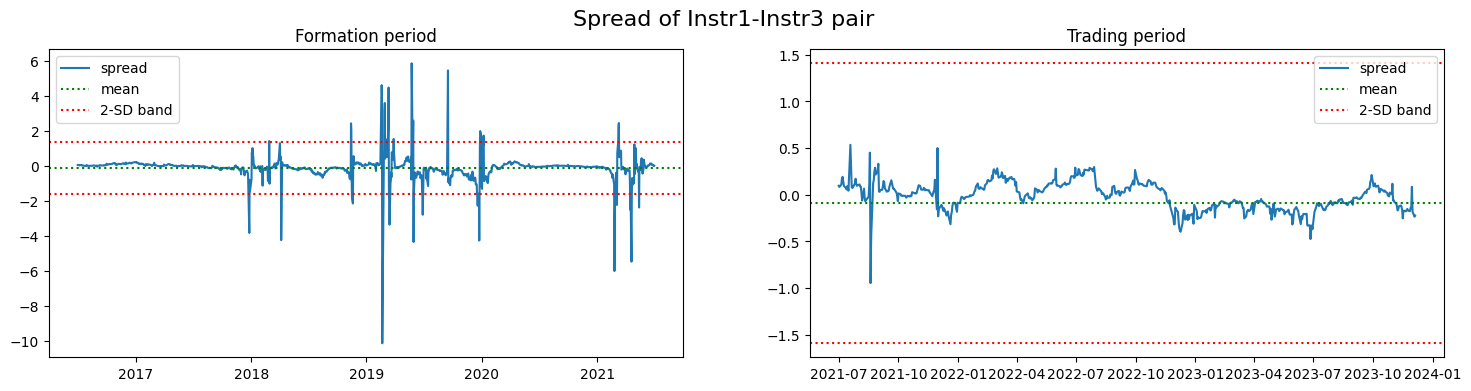

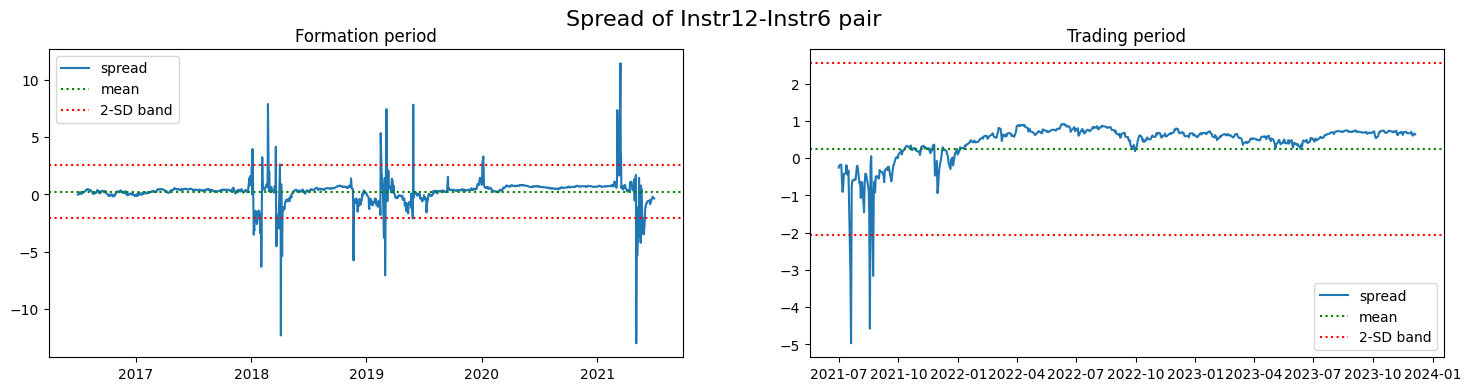

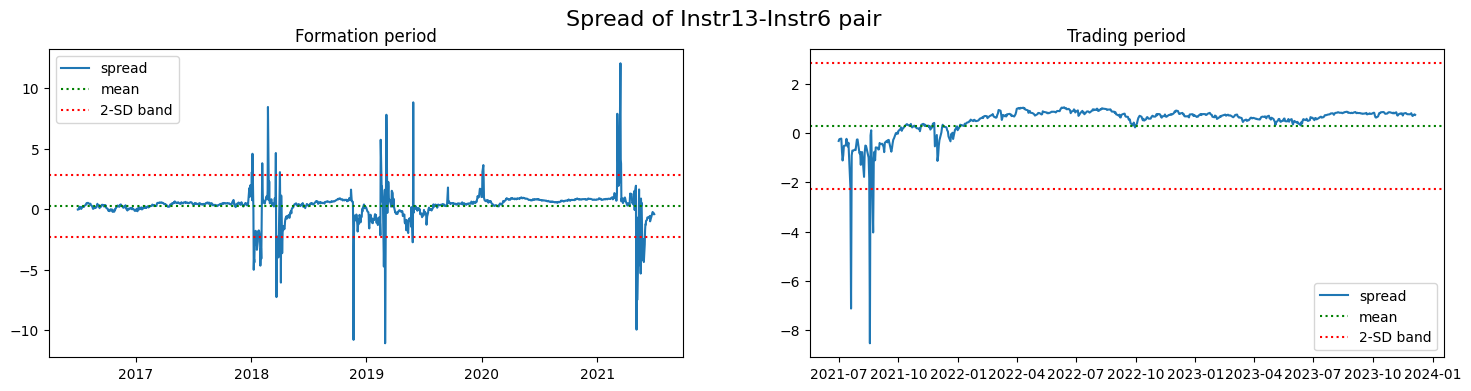

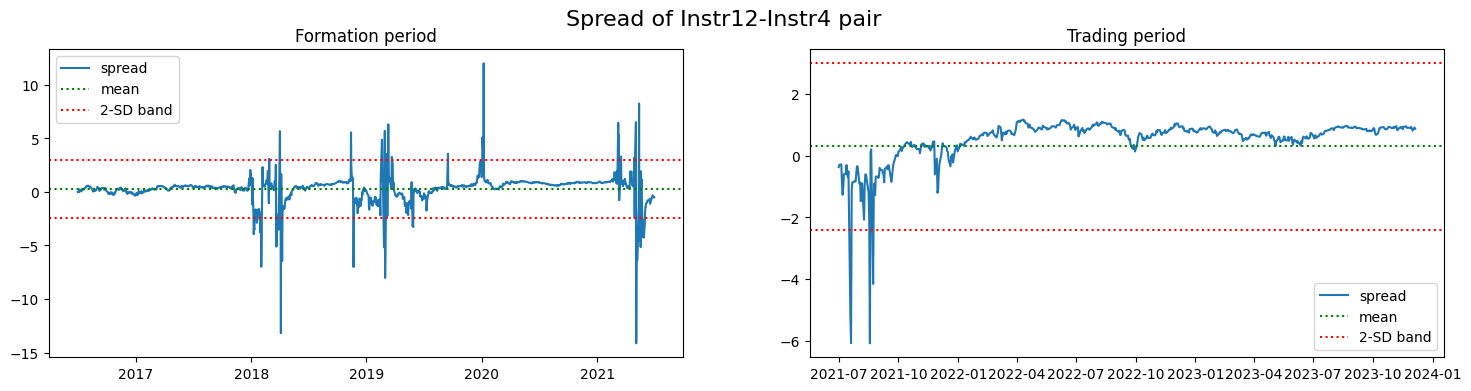

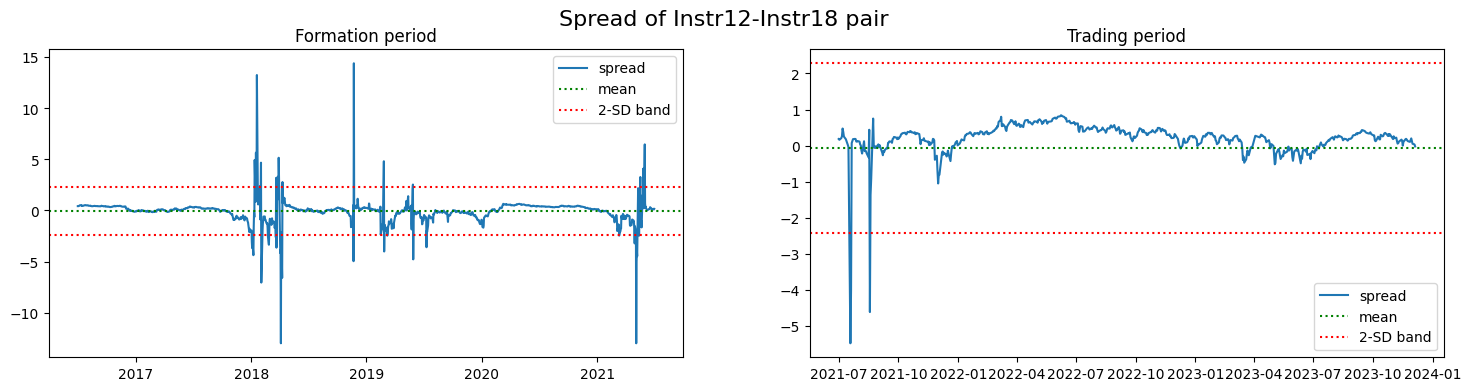

In [ ]:
top5_crossings = list(pairs60_24.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train60_24, test60_24)

In [ ]:
pairs12_6.sort_values(by='Pearson r', ascending=False)

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr13-Instr15,5.207439,59.0,0.980251,-0.011598,0.164921,0.377067,1.046612,0.958129
Instr2-Instr3,7.224833,49.0,0.973940,-0.019601,0.228813,0.398039,1.026466,0.986419
Instr13-Instr16,5.990257,55.0,0.973781,-0.015984,0.189713,0.342856,1.059581,0.957957
Instr5-Instr3,7.723215,68.0,0.966340,0.015500,0.244597,0.331505,1.086225,0.922349
Instr12-Instr15,7.079409,55.0,0.963564,-0.020289,0.224207,0.391095,1.157321,0.946647
...,...,...,...,...,...,...,...,...
Instr2-Instr19,23.608533,51.0,0.671360,-0.205452,0.747690,0.346770,2.429826,0.724783
Instr2-Instr20,24.090781,49.0,0.654260,-0.208690,0.762963,0.351028,2.521255,0.698508
Instr18-Instr1,22.494720,62.0,0.649270,0.063279,0.712415,0.350692,1.878428,0.588333
Instr19-Instr1,22.707783,68.0,0.638552,0.058873,0.719163,0.335207,1.984501,0.577254


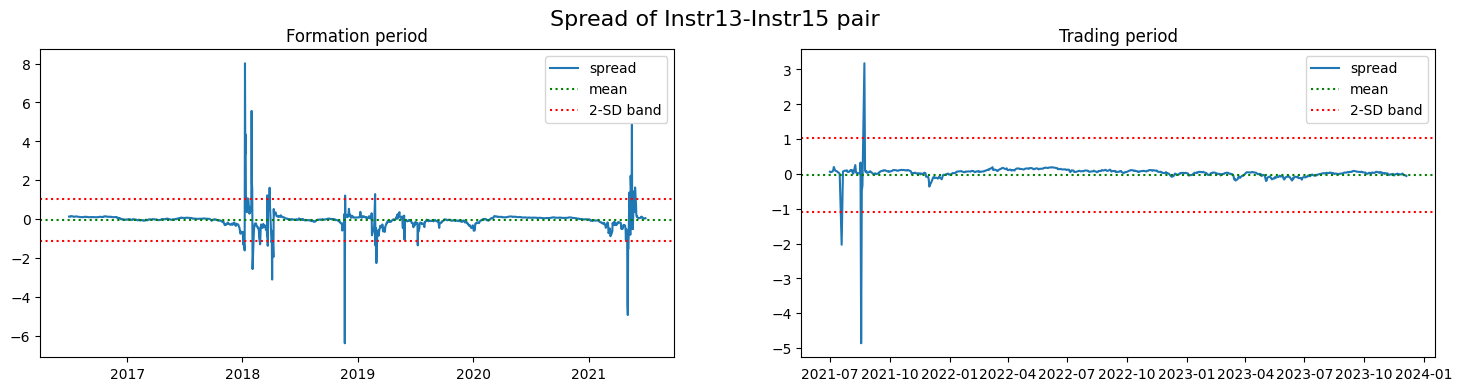

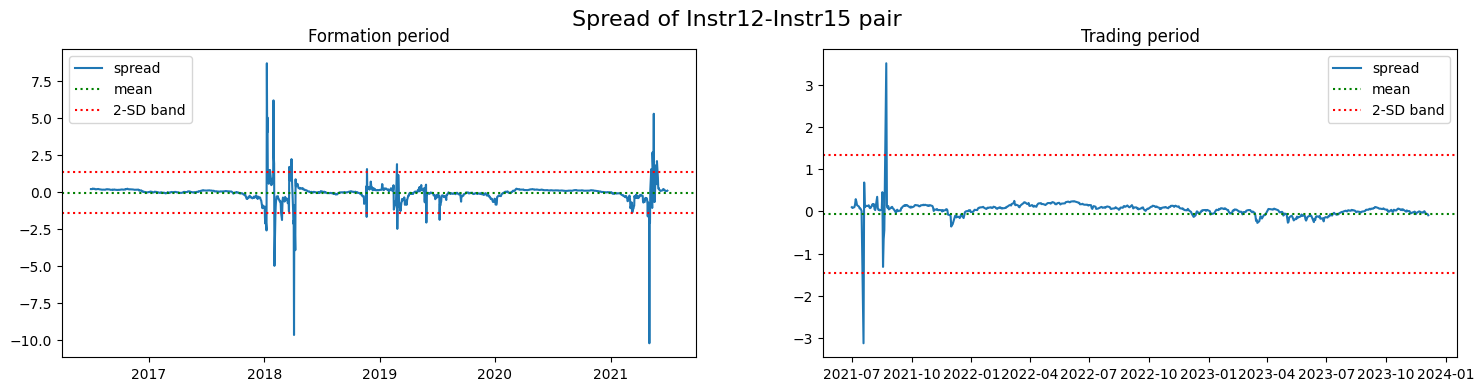

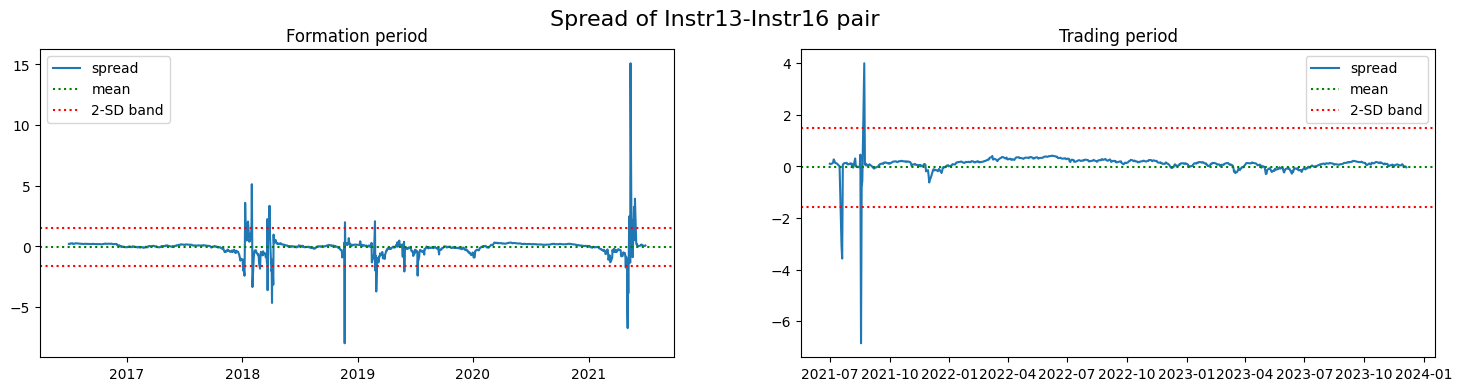

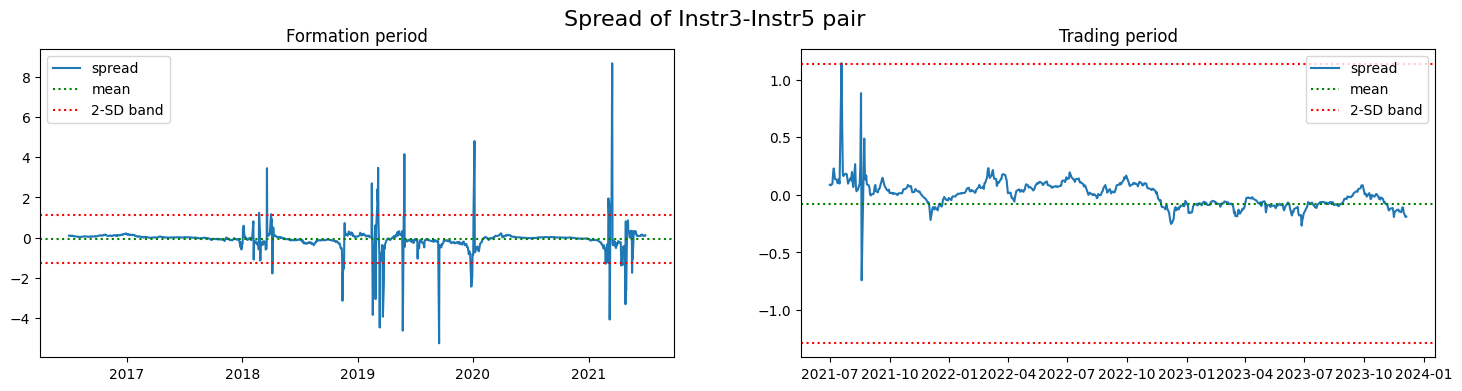

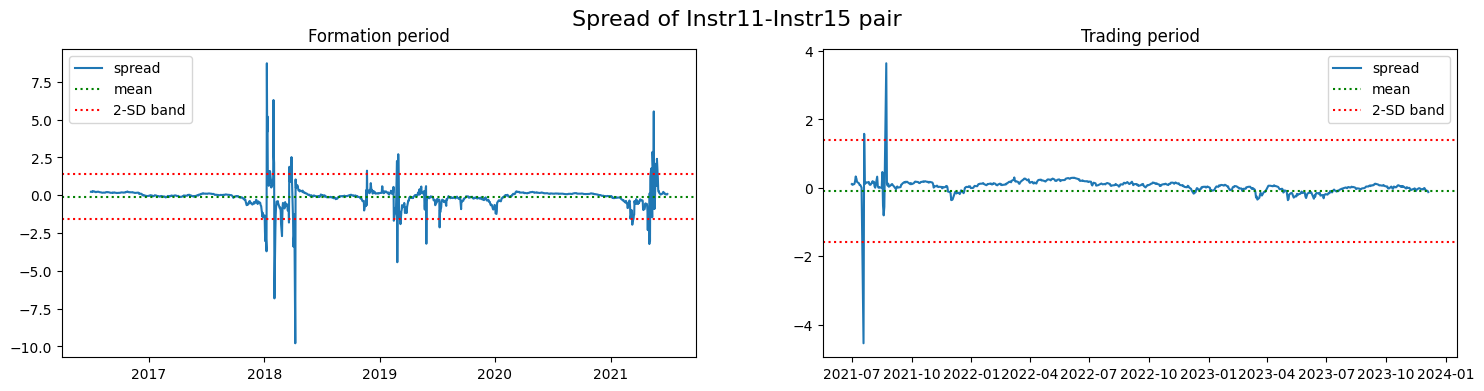

In [ ]:
top5_pearson = list(pairs60_24.sort_values(by='Pearson r', ascending=False).index[:5])
plot_pairs(top5_pearson, train60_24, test60_24)

In [ ]:
calculate_metrics(top5_pearson, test60_24, pairs60_24)

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr13-Instr15,6.80602,0.105225,0.031904,0.530154,0.993235,27,0.412932,0.809996,99.52381
Instr12-Instr15,6.177054,0.000573,0.000192,0.700426,0.993893,25,0.405215,0.784952,99.68254
Instr13-Instr16,10.65518,0.177136,0.080035,0.771717,0.985313,26,0.403663,0.939272,99.365079
Instr3-Instr5,3.596698,0.12077,0.043491,0.605939,0.995952,39,0.324847,2.132075,99.84127
Instr11-Instr15,7.694012,0.000004,0.000002,0.746596,0.989698,27,0.394432,0.719847,99.52381


In [ ]:
cumret36_12 = cumret.loc['2018-07-01':]
cumret36_12 = cumret36_12 / cumret36_12.iloc[0] # divide by first row so that all prices start at 1
train36_12 = cumret36_12.loc['2018-07-01':'2021-06-30'] # formation period
test36_12 = cumret36_12.loc['2021-07-01':'2022-12-30'] # trading period
pairs36_12 = select_pairs(train36_12)
pairs36_12

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr1-Instr2,302.256178,56.0,0.942880,-1.338424,10.871399,0.398899,1.189548,1.877755
Instr1-Instr3,346.331592,58.0,0.924283,-2.029637,12.456682,0.330456,1.259263,2.741791
Instr1-Instr4,400.575944,52.0,0.897264,-2.859424,14.407715,0.342512,1.287498,3.308698
Instr1-Instr5,432.289947,52.0,0.879203,-3.648437,15.548389,0.356308,1.556723,3.879247
Instr1-Instr6,488.529199,50.0,0.842669,-4.509302,17.571174,0.365234,1.439411,3.990843
...,...,...,...,...,...,...,...,...
Instr11-Instr20,53.433211,52.0,0.919377,-0.299288,1.921859,0.332488,1.034838,0.808848
Instr12-Instr17,43.188307,48.0,0.946460,-0.176493,1.553375,0.352644,1.127421,0.894668
Instr12-Instr20,51.927681,54.0,0.921598,-0.231724,1.867709,0.368081,1.042605,0.798579
Instr19-Instr1,106.292435,44.0,0.693197,0.966217,3.823073,0.359208,1.946129,0.112672


In [ ]:
pairs36_12.sort_values(by='Distance')

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr11-Instr9,15.924723,44.0,0.993104,0.186043,0.572772,0.356677,1.045161,0.914916
Instr11-Instr15,27.033981,48.0,0.979994,-0.215043,0.972345,0.320112,1.038366,1.026118
Instr7-Instr9,27.064520,44.0,0.987222,-0.303730,0.973443,0.379926,1.559003,1.137203
Instr11-Instr8,28.909045,50.0,0.977089,0.294750,1.039786,0.382857,1.005219,0.835002
Instr10-Instr7,32.850643,42.0,0.973425,0.327880,1.181556,0.419582,1.331013,0.822163
...,...,...,...,...,...,...,...,...
Instr1-Instr13,561.208231,56.0,0.785757,-8.290133,20.185257,0.335722,1.866106,5.285736
Instr1-Instr15,581.094428,56.0,0.767998,-8.842096,20.900514,0.322191,1.944251,5.371457
Instr1-Instr14,584.953550,50.0,0.764431,-8.514193,21.039317,0.350663,1.818643,5.121768
Instr1-Instr17,630.153181,48.0,0.719471,-9.012126,22.665035,0.327000,2.096889,4.612408


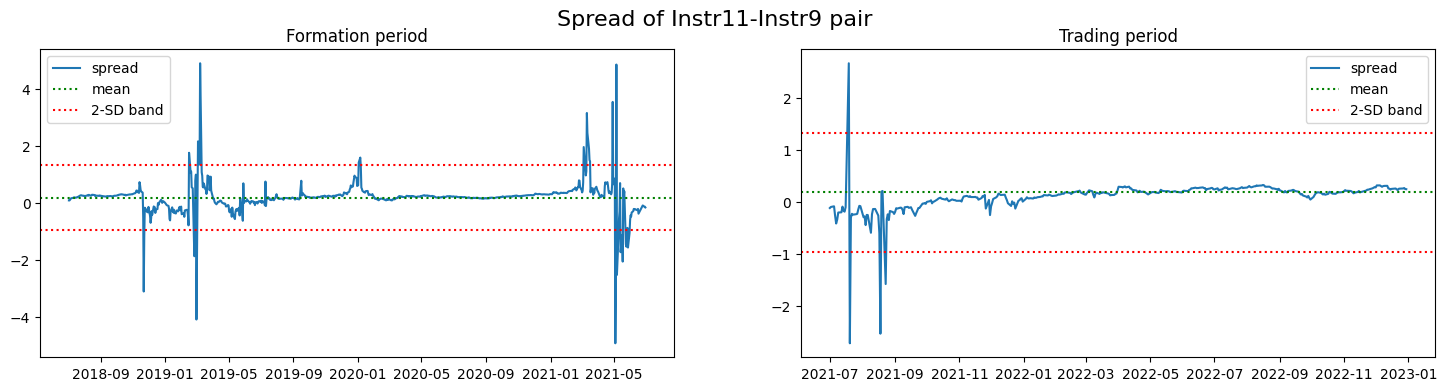

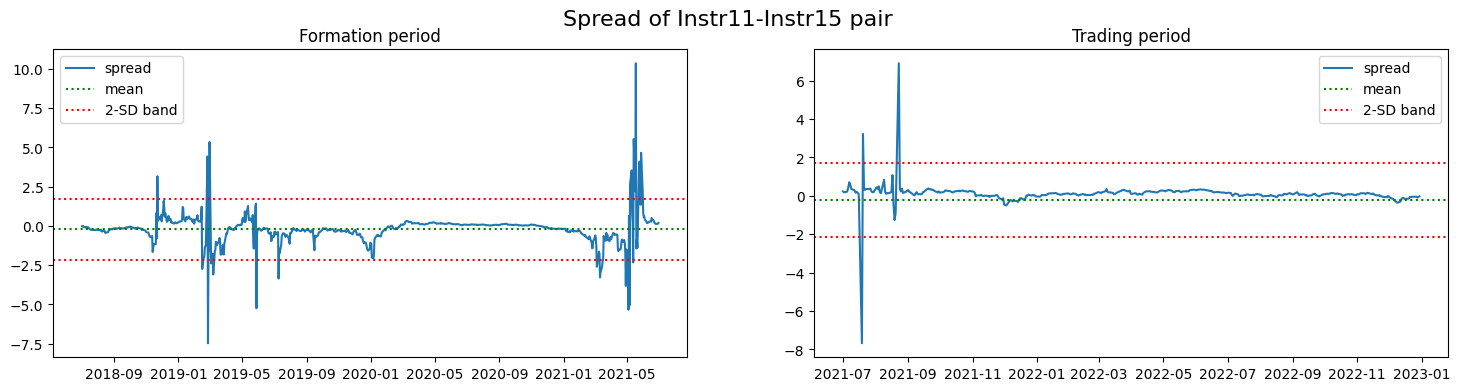

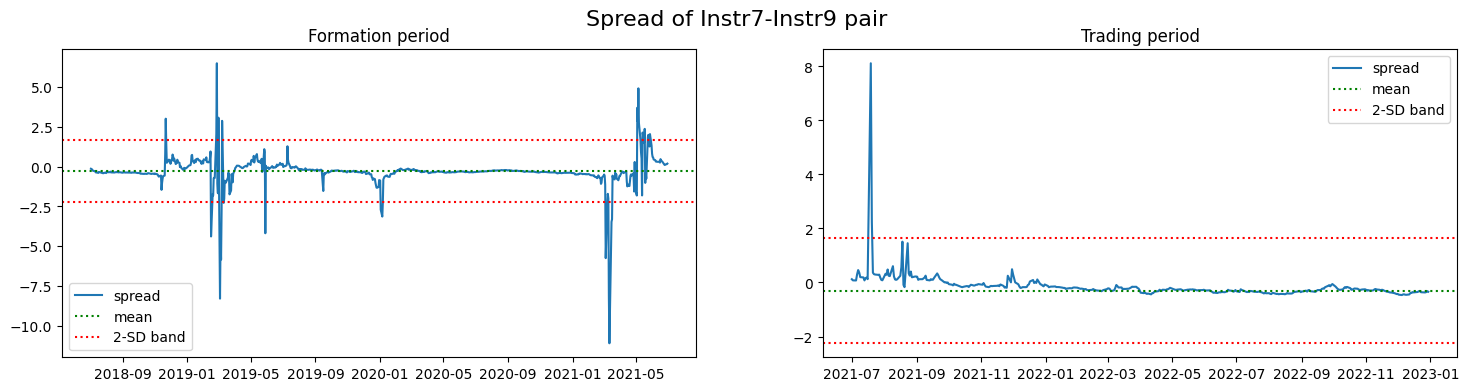

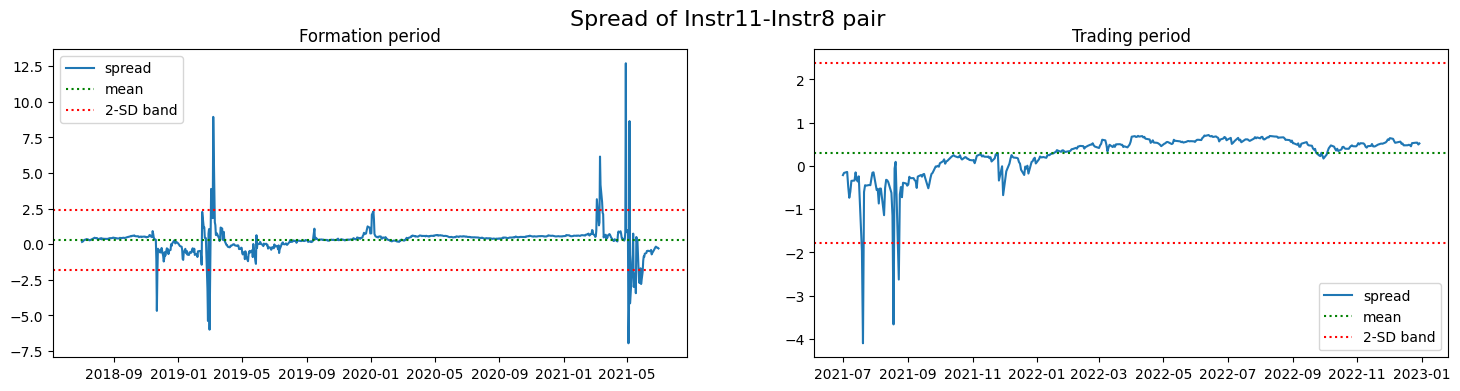

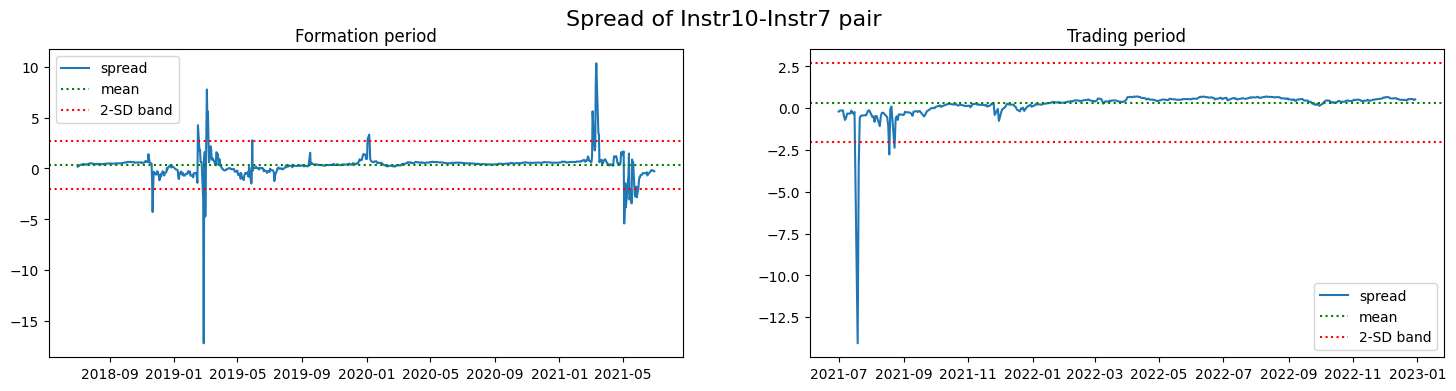

In [ ]:
top5_distance = list(pairs36_12.sort_values(by='Distance').index[:5])
plot_pairs(top5_distance, train36_12, test36_12)

In [ ]:
calculate_metrics(top5_distance, test36_12, pairs36_12)

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr11-Instr9,6.119072,0.000031,0.298437,0.572772,0.998077,31,0.326996,0.808459,98.974359
Instr11-Instr15,13.053656,0.000001,0.0,0.972345,0.990174,10,0.400184,0.607914,99.230769
Instr7-Instr9,10.315491,0.000019,0.0,0.973443,0.997071,25,0.369647,1.198675,99.487179
Instr11-Instr8,9.996797,0.001293,0.361059,1.039786,0.998489,5,0.310305,2.517499,98.974359
Instr10-Instr7,16.905438,0.0,0.0,1.181556,0.989585,9,0.369848,1.163629,98.974359


In [ ]:
pairs36_12.sort_values(by='Num zero-crossings', ascending=False)


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr2-Instr8,223.826736,62.0,0.870998,-2.435586,8.050488,0.302619,1.055196,2.496587
Instr3-Instr5,93.191525,60.0,0.952454,-0.587531,3.351866,0.296795,1.142034,1.416684
Instr10-Instr18,58.887734,60.0,0.911853,-0.376081,2.118045,0.375410,1.003025,0.914117
Instr2-Instr12,256.203653,60.0,0.826898,-3.579138,9.215005,0.318772,1.514709,2.815950
Instr2-Instr11,239.342793,60.0,0.850891,-3.370484,8.608562,0.297091,1.469731,2.853972
...,...,...,...,...,...,...,...,...
Instr6-Instr15,91.627525,40.0,0.878213,-1.094249,3.295613,0.319215,1.387199,1.296953
Instr6-Instr14,93.024377,40.0,0.874202,-1.015052,3.345854,0.340311,1.189846,1.236762
Instr4-Instr11,110.811770,40.0,0.892845,-1.454054,3.985622,0.284406,1.121410,1.617327
Instr6-Instr12,78.765924,40.0,0.911574,-0.895873,2.833013,0.348398,1.267545,1.305387


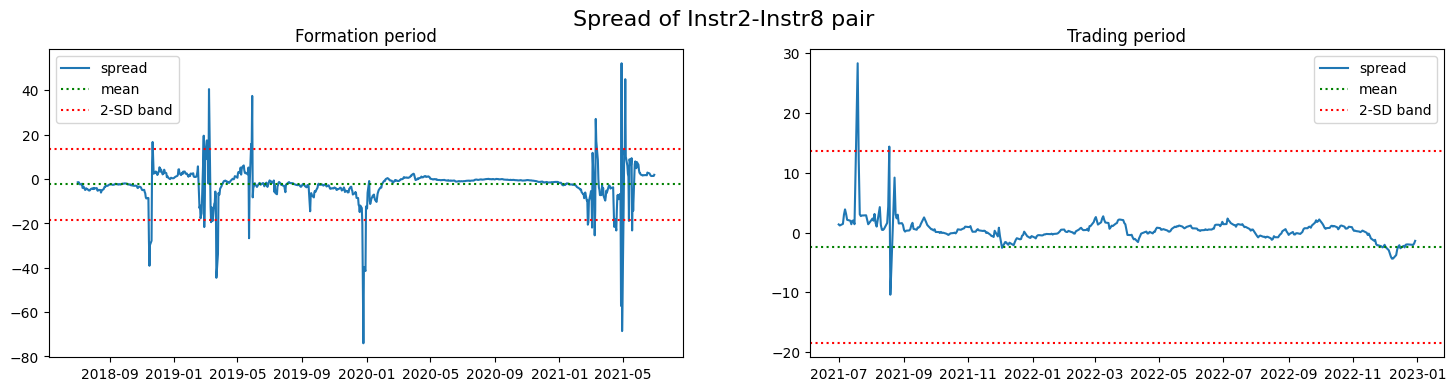

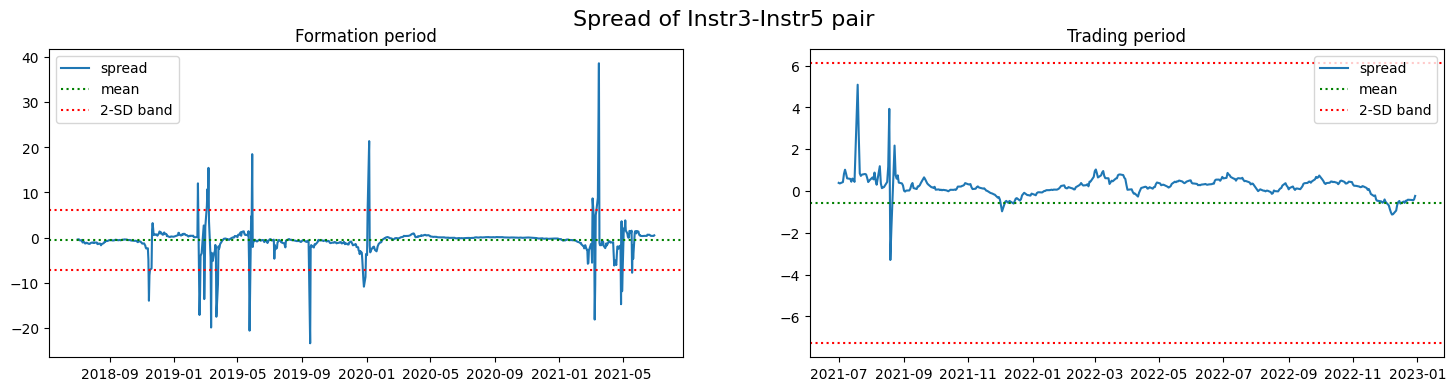

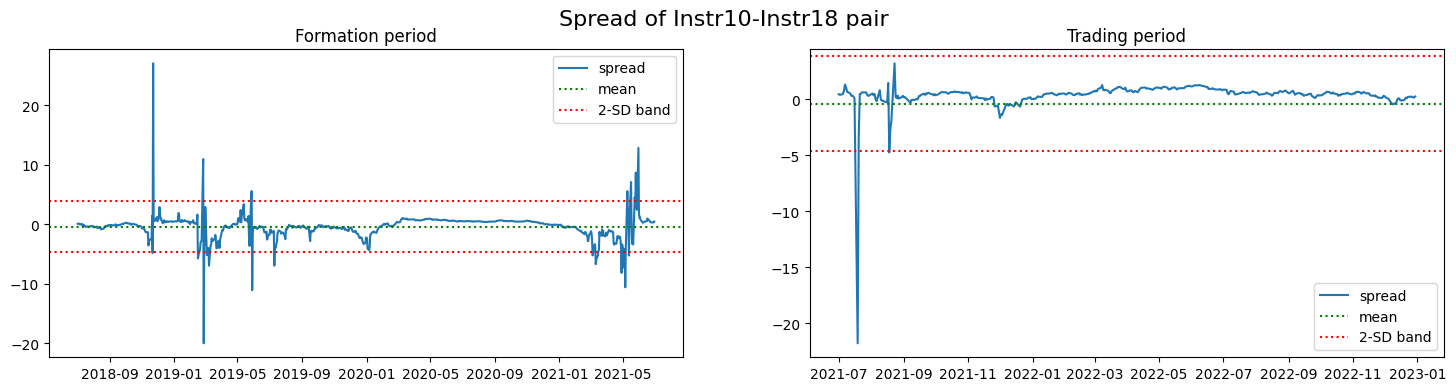

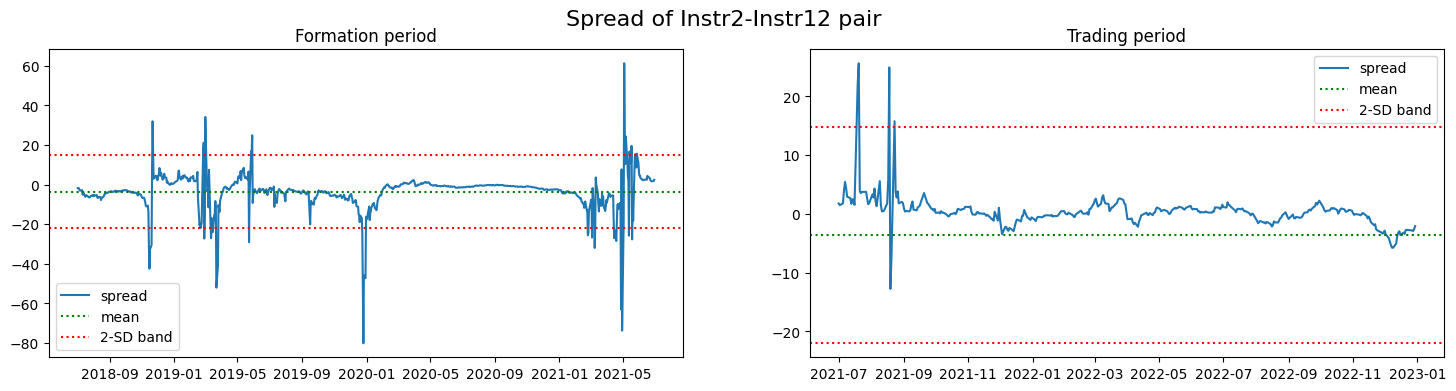

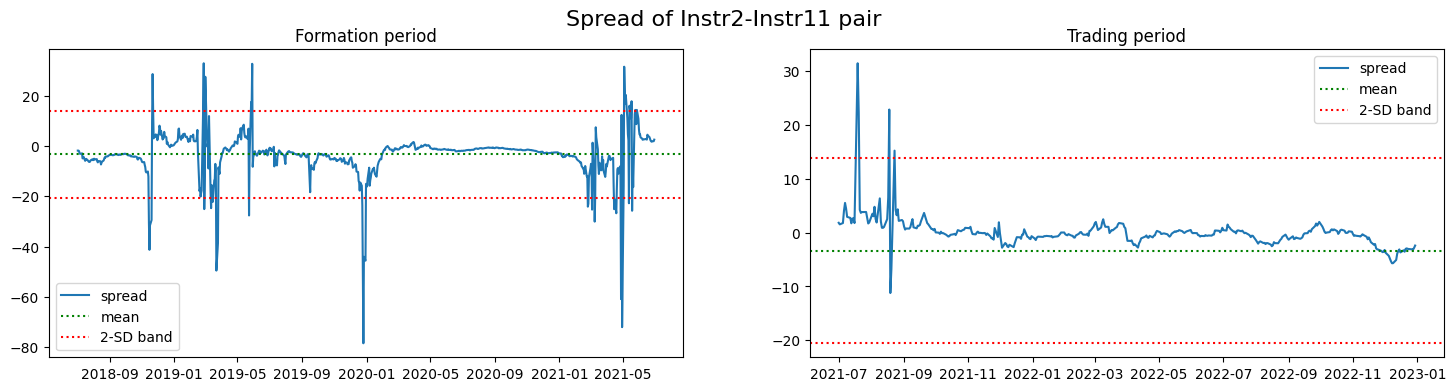

In [ ]:
top5_crossings = list(pairs36_12.sort_values(by='Num zero-crossings', ascending=False).index[:5])
plot_pairs(top5_crossings, train36_12, test36_12)

In [ ]:
calculate_metrics(top5_crossings, test36_12, pairs36_12)


,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr2-Instr8,72.202068,0.006756,0.012708,8.050488,0.97888,12,0.355783,1.288593,99.487179
Instr3-Instr5,19.316213,0.158913,0.048088,3.351866,0.996987,10,0.310929,1.411951,100.0
Instr10-Instr18,29.166026,0.0,0.0,2.118045,0.963035,10,0.393232,0.945943,99.487179
Instr2-Instr12,96.85644,0.025921,0.055358,9.215005,0.968543,4,0.29142,1.274748,98.974359
Instr2-Instr11,90.106072,0.100198,0.051622,8.608562,0.970379,10,0.321909,1.411833,98.974359


In [ ]:
pairs36_12.sort_values(by='Pearson r', ascending=False)


,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
Instr11-Instr9,15.924723,44.0,0.993104,0.186043,0.572772,0.356677,1.045161,0.914916
Instr7-Instr9,27.064520,44.0,0.987222,-0.303730,0.973443,0.379926,1.559003,1.137203
Instr11-Instr15,27.033981,48.0,0.979994,-0.215043,0.972345,0.320112,1.038366,1.026118
Instr11-Instr8,28.909045,50.0,0.977089,0.294750,1.039786,0.382857,1.005219,0.835002
Instr10-Instr7,32.850643,42.0,0.973425,0.327880,1.181556,0.419582,1.331013,0.822163
...,...,...,...,...,...,...,...,...
Instr1-Instr17,630.153181,48.0,0.719471,-9.012126,22.665035,0.327000,2.096889,4.612408
Instr2-Instr19,317.793373,48.0,0.716549,-4.195478,11.430233,0.326278,1.887059,2.213627
Instr2-Instr20,321.789113,46.0,0.707905,-4.250464,11.573950,0.334544,1.902681,2.088931
Instr1-Instr18,648.470235,50.0,0.699420,-9.107032,23.323853,0.362086,2.111783,4.434871


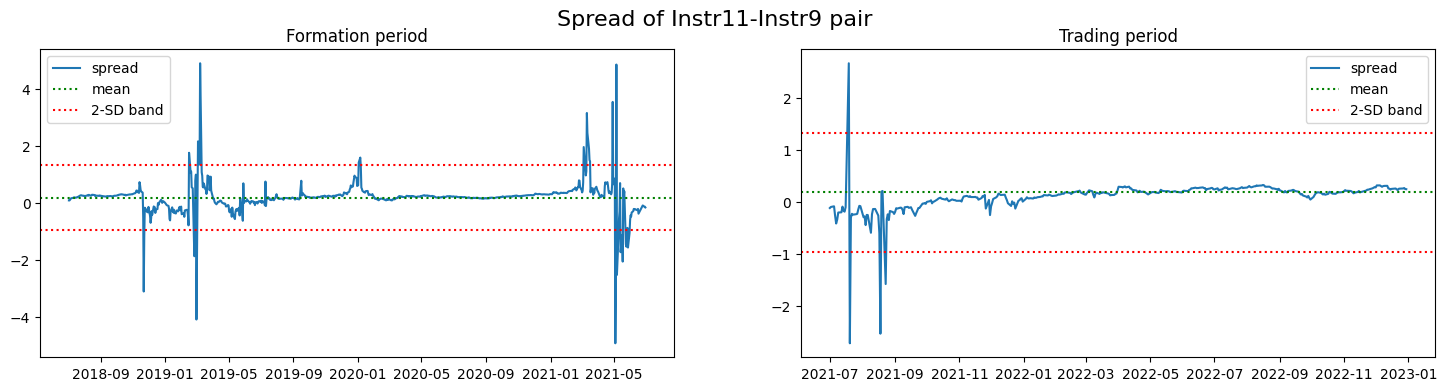

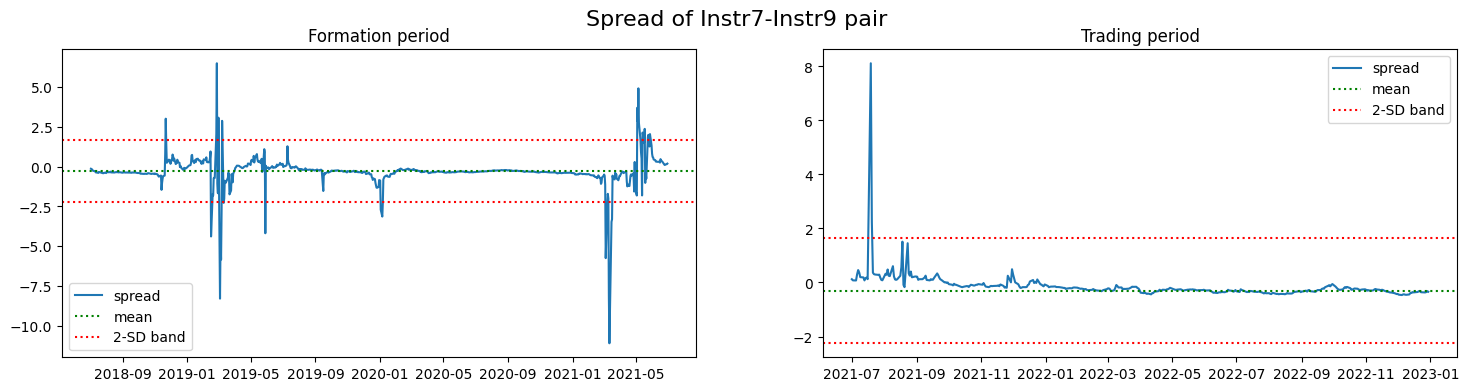

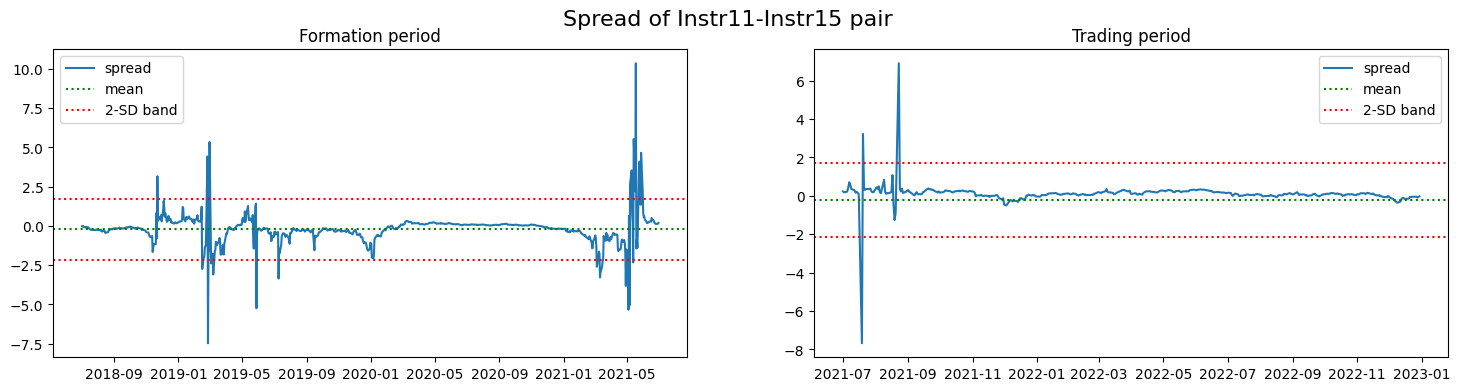

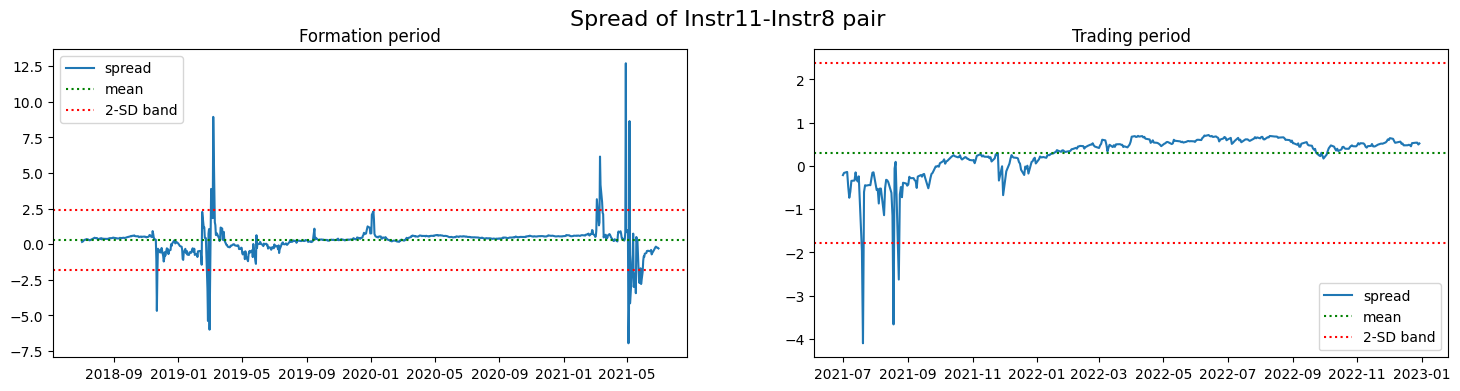

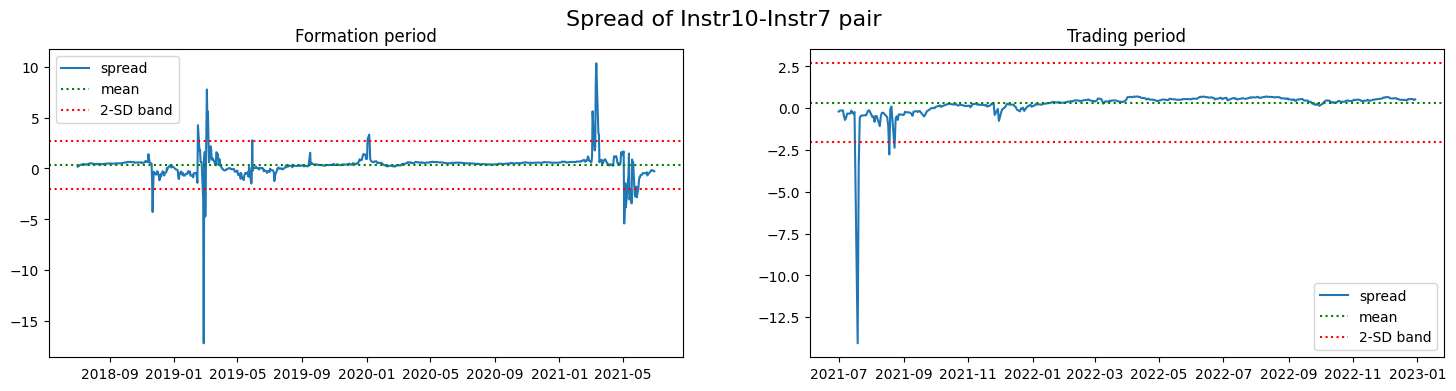

In [ ]:
top5_pearson = list(pairs36_12.sort_values(by='Pearson r', ascending=False).index[:5])
plot_pairs(top5_pearson, train36_12, test36_12)

In [ ]:
calculate_metrics(top5_pearson, test36_12, pairs36_12)


,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
Instr11-Instr9,6.119072,0.000031,0.298437,0.572772,0.998077,31,0.326996,0.808459,98.974359
Instr7-Instr9,10.315491,0.000019,0.0,0.973443,0.997071,25,0.369647,1.198675,99.487179
Instr11-Instr15,13.053656,0.000001,0.0,0.972345,0.990174,10,0.400184,0.607914,99.230769
Instr11-Instr8,9.996797,0.001293,0.361059,1.039786,0.998489,5,0.310305,2.517499,98.974359
Instr10-Instr7,16.905438,0.0,0.0,1.181556,0.989585,9,0.369848,1.163629,98.974359
